In [1]:
from heston_asian_option import HestonAsianOption
from plots import *

In [2]:
# Parameters
S0 = 100       # initial stock price
r = 0.05       # risk-free rate
T = 1.0        # time to maturity (1 year)
K = 100        # strike price 
V0 = 0.04      # initial variance (sqrt(0.04) = 0.2 initial volatility)
kappa = 2.0    # mean reversion speed
theta = 0.04   # long-term variance
xi = 0.3       # volatility of volatility
rho = -0.7     # correlation between stock and variance processes
N = 252        # number of time steps (daily)
M = 20000     # number of simulation paths

pricer = HestonAsianOption(S0, r, T, K, V0, kappa, theta, xi, rho, N, M)

Task 1: Basic Monte Carlo (Euler scheme)
Price: 5.676734
Standard Error: 0.048194
95% Confidence Interval: [5.582273, 5.771195]
Computation Time: 0.30 seconds



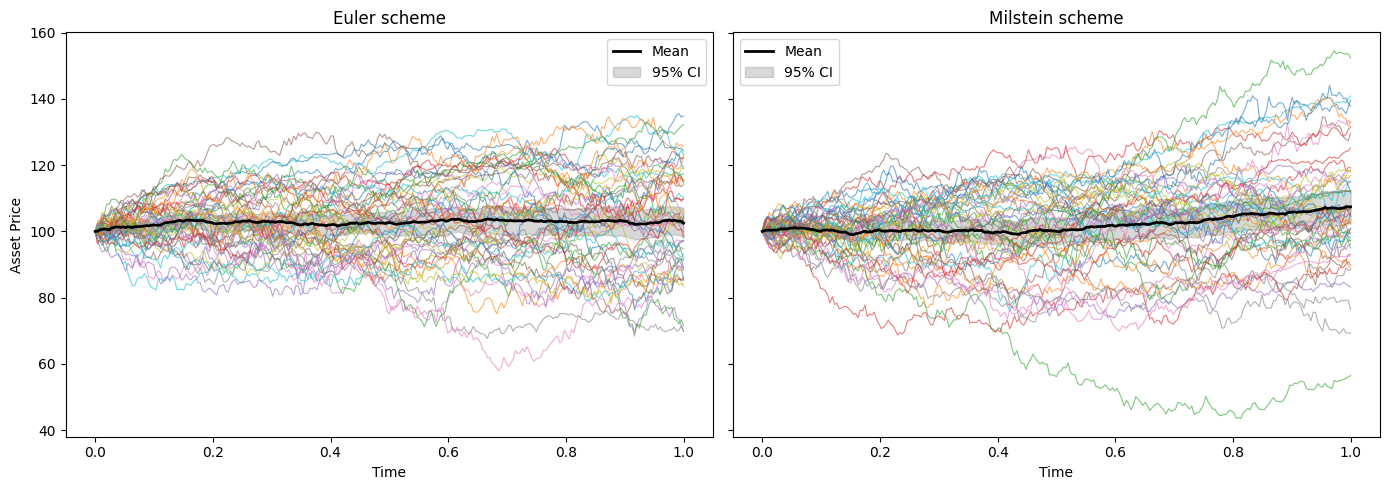

In [3]:
price, std_error, computation_time = pricer.price_arithmetic_asian_option()
print("Task 1: Basic Monte Carlo (Euler scheme)")
print(f"Price: {price:.6f}")
print(f"Standard Error: {std_error:.6f}")
print(f"95% Confidence Interval: [{price - 1.96*std_error:.6f}, {price + 1.96*std_error:.6f}]")
print(f"Computation Time: {computation_time:.2f} seconds\n")

plot_heston_paths_with_ci(pricer)

In [4]:
# Compare Euler vs Milstein schemes
schemes_comparison = pricer.compare_schemes()
print("Comparison of Discretization Schemes:")
print(f"Euler - Price: {schemes_comparison['euler']['price']:.6f}, Std Error: {schemes_comparison['euler']['std_error']:.6f}, Time: {schemes_comparison['euler']['time']:.2f}s")
print(f"Milstein - Price: {schemes_comparison['milstein']['price']:.6f}, Std Error: {schemes_comparison['milstein']['std_error']:.6f}, Time: {schemes_comparison['milstein']['time']:.2f}s\n")

Comparison of Discretization Schemes:
Euler - Price: 5.818796, Std Error: 0.048740, Time: 0.31s
Milstein - Price: 5.807837, Std Error: 0.048759, Time: 0.33s



TODO: Verify your implementation by temporarily setting volatility-of-volatility ξ = 0 (reducing Heston to GBM) and comparing your results against known or approximated benchmarks.

The “σ” you pass into verify_with_gbm(self, sigma, …) is simply the Black–Scholes (constant) volatility that your GBM has once you set ξ=0. In other words, when you collapse Heston to GBM, the instantaneous variance process becomes deterministic—so you must choose what constant volatility that GBM is supposed to have.

In [17]:
# 1) Compare Euler vs Milstein under Heston
pricer.M = int(1e5)
schemes_comparison = pricer.compare_schemes()
print("Comparison of Discretization Schemes under Heston:")
print(f"  Euler   - Price: {schemes_comparison['euler']['price']:.6f}, "
      f"Std Error: {schemes_comparison['euler']['std_error']:.6f}, "
      f"Time: {schemes_comparison['euler']['time']:.2f}s")
print(f"  Milstein- Price: {schemes_comparison['milstein']['price']:.6f}, "
      f"Std Error: {schemes_comparison['milstein']['std_error']:.6f}, "
      f"Time: {schemes_comparison['milstein']['time']:.2f}s")
print()

# 2) Verify GBM benchmarks (ξ=0) with simpler Kemna–Vorst σ̃
sigma = np.sqrt(pricer.V0)
gbm = pricer.verify_with_gbm(sigma)
mc    = gbm['mc_arithmetic_price']
mc_se = gbm['mc_arithmetic_std_error']
geo   = gbm['analytic_geometric_price']   # simpler σ̃ Kemna–Vorst
tw    = gbm['turnbull_wakeman_approx']

print(f"Verification under GBM (ξ=0), σ = sqrt(V0) = {sigma:.4f}:")
print(f"  MC Arithmetic-Asian         : {mc:.6f} ± {mc_se:.6f}")
print(f"  Simple Kemna–Vorst Geometric: {geo:.6f}   (approx)")
print(f"  Turnbull–Wakeman Approx     : {tw:.6f}   (approx)")
print()

# 3) Report approximation errors
err_geo = 100 * abs(geo - mc) / mc
err_tw  = 100 * abs(tw  - mc) / mc

print(f"Approximation error of simple Geometric vs MC: {err_geo:.2f}%")
print(f"Approximation error of TW approx vs MC      : {err_tw:.2f}%")


Comparison of Discretization Schemes under Heston:
  Euler   - Price: 15.309858, Std Error: 0.055127, Time: 38.89s
  Milstein- Price: 15.250123, Std Error: 0.054801, Time: 16.27s

Verification under GBM (ξ=0), σ = sqrt(V0) = 0.2000:
  MC Arithmetic-Asian         : 15.285786 ± 0.064185
  Simple Kemna–Vorst Geometric: 6.459059   (approx)
  Turnbull–Wakeman Approx     : 5.787541   (approx)

Approximation error of simple Geometric vs MC: 57.74%
Approximation error of TW approx vs MC      : 62.14%


## Analytical Geometric-Asian Price as Control Variate Reference

We chose as volatility of the GBM control variate the square root of the volatility of the arithmetic. The key is that once you kill off the stochastic term (ξ=0), the Heston variance:
$$
dv_t = \kappa\,(\theta - v_t)\,dt
$$

becomes a purely deterministic ODE.  Its general solution is

$$ v_t = \theta + (v_0 - \theta)e^{-\kappa t} $$

By choosing $\theta = V_0$: 

$$ v_t = V_0 + (V_0 - V_0) e^{-\kappa t} = V_0\quad\forall t $$

The whole variance path stays constant at V₀, so we set

$$ \sigma = \sqrt{v_t} = \sqrt{V_0}\, $$

and recover the standard GBM

$$ dS_t = r S_t dt + \sqrt{V_0} S_t dW_t. $$

In [10]:
# Task 2: Analytical Geometric-Asian Price as Control Variate Reference
# We use the initial volatility from Heston model
sigma = np.sqrt(V0) 
print("Task 2: Analytical Geometric-Asian Price as Control Variate")
print(f"Selected sigma for GBM: {sigma:.6f} (square root of initial variance v0)")
geo_price = pricer.analytical_geometric_asian_price(sigma)
print(f"Analytical Geometric Asian Option Price: {geo_price:.6f}\n")

Task 2: Analytical Geometric-Asian Price as Control Variate
Selected sigma for GBM: 0.200000 (square root of initial variance v0)
Analytical Geometric Asian Option Price: 6.455301



In [11]:
#TODO: Test your implementation on known scenarios to ensure accuracy.

## Implementing the Control Variate Monte Carlo

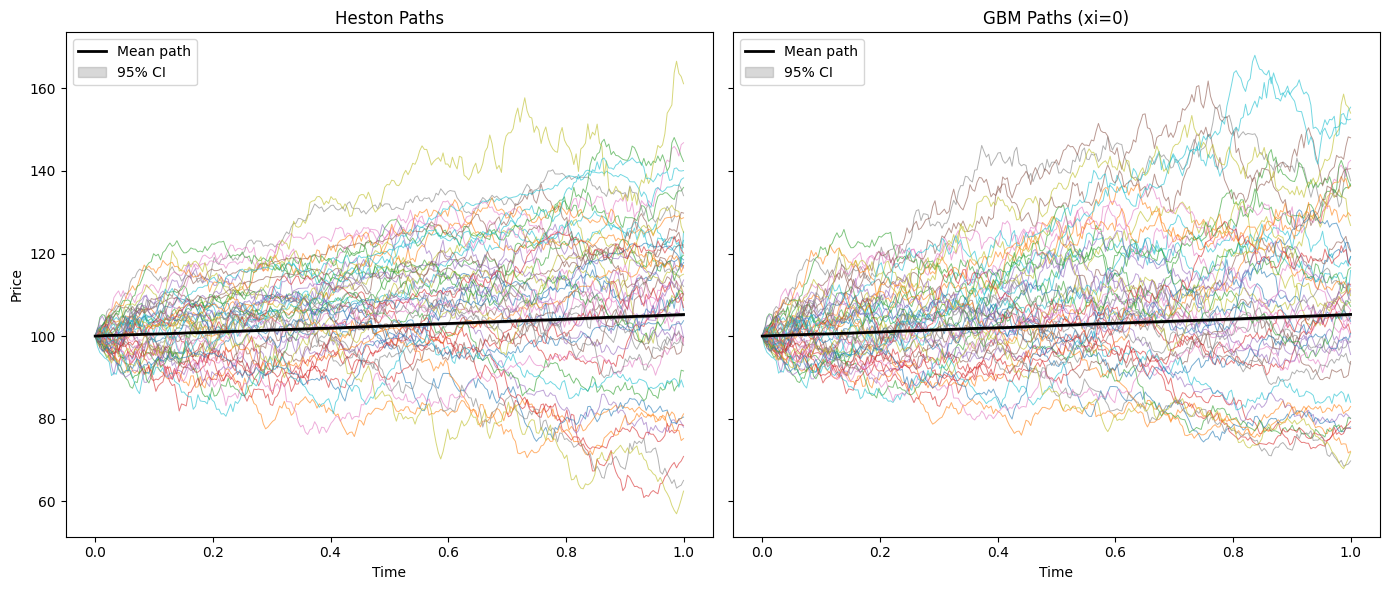

In [18]:
# Generate Heston paths
S_heston, _ = pricer.generate_paths()

# Generate parallel GBM paths using the same random numbers
S_gbm = pricer.generate_gbm_paths(sigma)

compare_path_sets(S_heston, S_gbm, T=pricer.T, title1='Heston Paths',title2='GBM Paths (xi=0)')

In [19]:
cv_results = pricer.control_variate_monte_carlo(S_heston, S_gbm, sigma)
print(f"Price without control variate: {cv_results['price_without_cv']:.6f}")
print(f"Standard Error without control variate: {cv_results['std_error_without_cv']:.6f}")
print(f"Price with control variate (c=1): {cv_results['price_with_cv']:.6f}")
print(f"Standard Error with control variate (c=1): {cv_results['std_error_with_cv']:.6f}")
print(f"Optimal Control Coefficient: {cv_results['optimal_control_coefficient']:.6f}")
print(f"Price with Optimal control variate: {cv_results['price_with_optimal_cv']:.6f}")
print(f"Standard Error with Optimal control variate: {cv_results['std_error_with_optimal_cv']:.6f}")
print(f"Variance plain: {cv_results['variance_plain']:.6f}")
print(f"Variance CV: {cv_results['variance_cv']:.6f}")
print(f"Variance Optimal CV: {cv_results['variance_optimal_cv']:.6f}")
print(f"Variance Reduction Factor (c=1): {cv_results['variance_reduction_factor_c1']:.2f}x")
print(f"Variance Reduction Factor (optimal): {cv_results['variance_reduction_factor_optimal']:.2f}x")
print(f"Computation Time: {cv_results['computation_time']:.2f} seconds\n")
    

Price without control variate: 5.807603
Standard Error without control variate: 0.048725
Price with control variate (c=1): 6.939440
Standard Error with control variate (c=1): 0.017878
Optimal Control Coefficient: 0.837503
Price with Optimal control variate: 6.803906
Standard Error with Optimal control variate: 0.016789
Variance plain: 47.481928
Variance CV: 6.392674
Variance Optimal CV: 5.637684
Variance Reduction Factor (c=1): 7.43x
Variance Reduction Factor (optimal): 8.42x
Computation Time: 0.05 seconds



## Experiments and Comparative Analysis
### Variance Reduction Efficacy

In [20]:
path_counts = np.logspace(2, 5, num=10, dtype=int)
results = pricer.experiment_varying_paths(sigma, path_counts)
print("Paths\tPrice (No CV)\tStd Err (No CV)\tPrice (CV)\tStd Err (CV)\tVR Factor")
for i in range(len(path_counts)):
    print(f"{path_counts[i]}\t{results['price_without_cv'][i]:.6f}\t"
            f"{results['std_error_without_cv'][i]:.6f}\t"
            f"{results['price_with_optimal_cv'][i]:.6f}\t"
            f"{results['std_error_with_optimal_cv'][i]:.6f}\t"
            f"{results['variance_reduction_factor_optimal'][i]:.2f}x")

Paths	Price (No CV)	Std Err (No CV)	Price (CV)	Std Err (CV)	VR Factor
100	6.108109	0.669504	7.058179	0.197155	11.53x
215	5.611079	0.496435	6.937948	0.160558	9.56x
464	6.257376	0.336923	6.855551	0.115120	8.57x
1000	5.931085	0.221468	6.969089	0.077983	8.07x
2154	5.680656	0.146858	6.787762	0.051864	8.02x
4641	5.676260	0.100609	6.803958	0.033968	8.77x
10000	5.789612	0.069166	6.826444	0.023500	8.66x
21544	5.800259	0.046798	6.817378	0.016160	8.39x
46415	5.757809	0.031669	6.815561	0.010785	8.62x
100000	5.728412	0.021607	6.815502	0.007411	8.50x


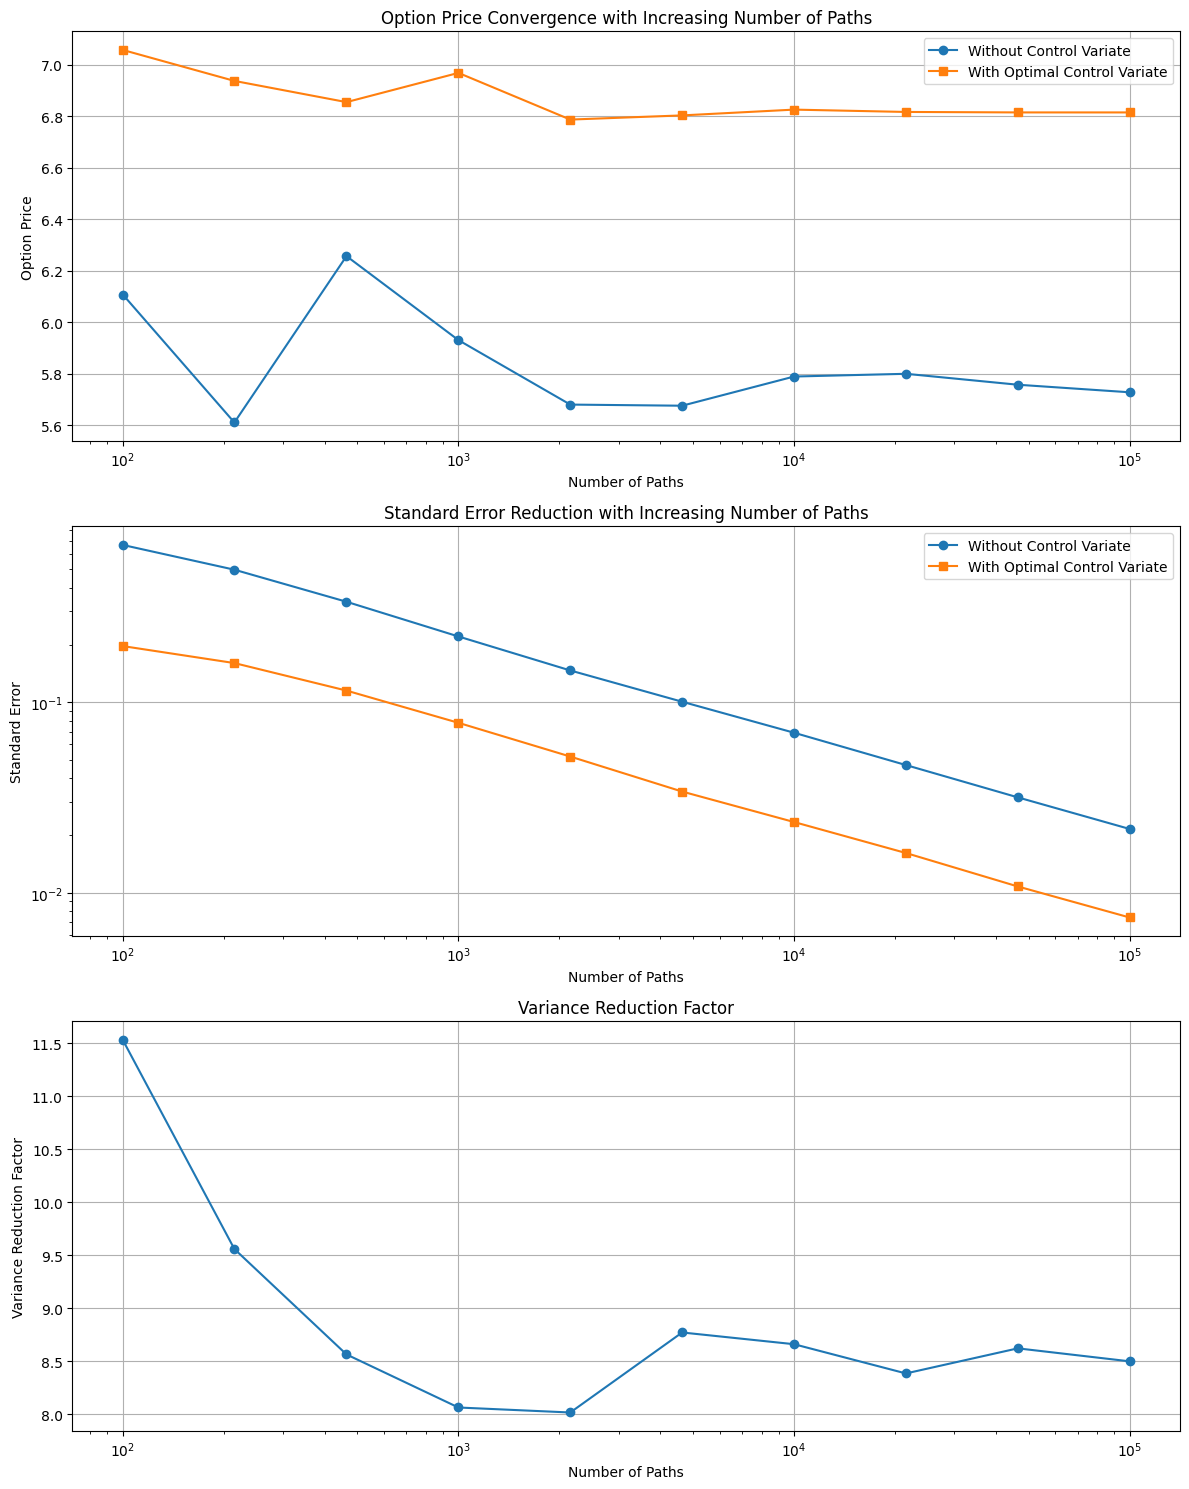

In [21]:
plot_variance_reduction_efficacy(results)

### Impact of Varying Heston Parameters

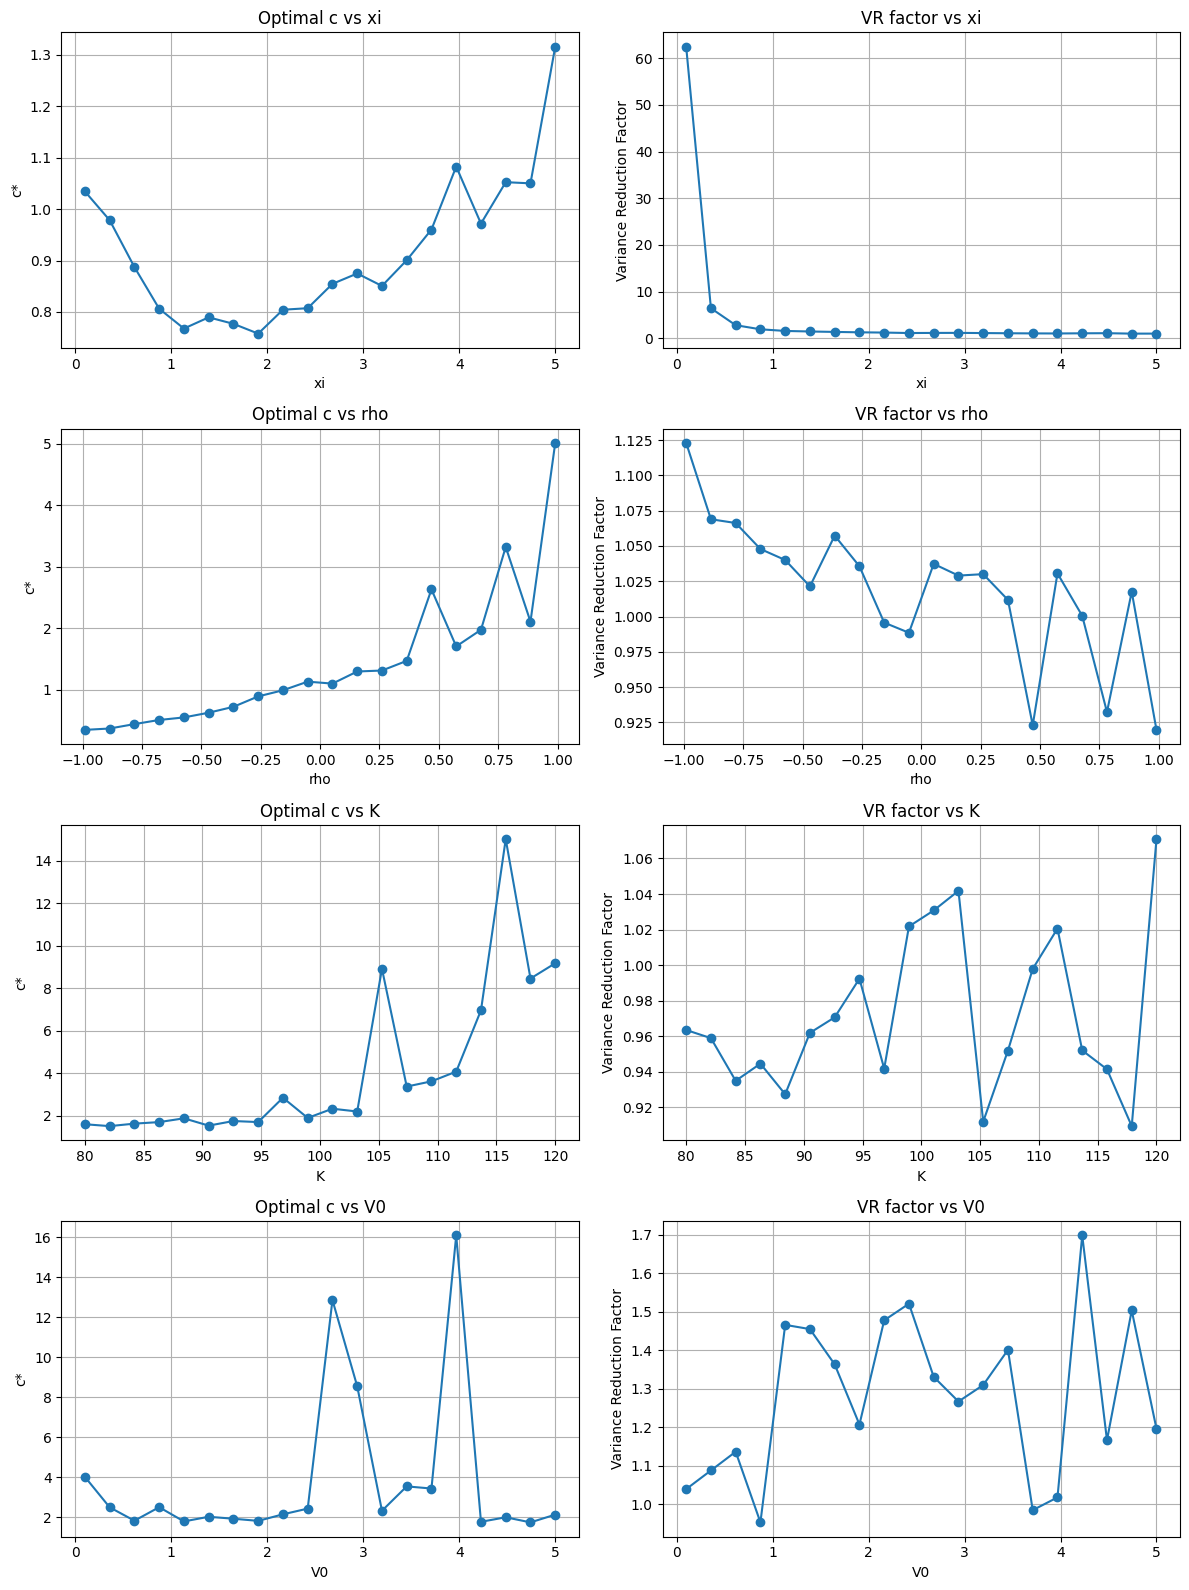

In [22]:
rho_values=np.linspace(-0.99, 0.99, 20)
xi_values=np.linspace(0.1, 5, 20)
K_values=np.linspace(80, 120, 20)
v0_values=np.linspace(0.1, 5, 20)
plot_optimal_control_coefficient(rho_values, xi_values, K_values, v0_values)

### Impact of varying frequencies

In [23]:
frequencies = [12, 52, 252]  # monthly, weekly, daily, hourly
frequency_results = pricer.experiment_averaging_frequency(sigma, frequencies)
print("Task 4c: Impact of Averaging Frequency")
print("Frequency\tPrice (No CV)\tStd Err (No CV)\tPrice (CV)\tStd Err (CV)\tVR Factor")
for i in range(len(frequencies)):
    print(f"{frequencies[i]}\t{frequency_results['price_without_cv'][i]:.6f}\t"
            f"{frequency_results['std_error_without_cv'][i]:.6f}\t"
            f"{frequency_results['price_with_cv'][i]:.6f}\t"
            f"{frequency_results['std_error_with_cv'][i]:.6f}\t"
            f"{frequency_results['variance_reduction_factor'][i]:.2f}x")
    
# Optimal c* already found, maybe move here

Task 4c: Impact of Averaging Frequency
Frequency	Price (No CV)	Std Err (No CV)	Price (CV)	Std Err (CV)	VR Factor
12	6.162710	0.052345	6.822536	0.019751	7.02x
52	5.866800	0.049173	6.832538	0.017477	7.92x
252	5.822363	0.048792	6.842058	0.016552	8.69x


In [24]:
#TODO: Try wwith different control variates

In [25]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the API client with cache and retry
cache_session = requests_cache.CachedSession('.cache', expire_after=3600)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)

openmeteo = openmeteo_requests.Client(session=retry_session)

url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
    "latitude": 52.37,
    "longitude": 4.89,
    "start_date": "2020-08-10",
    "end_date": "2024-08-23",
    "hourly": "temperature_2m",
    "daily": "temperature_2m_mean"
}

responses = openmeteo.weather_api(url, params=params)
response = responses[0]

# Process daily data
daily = response.Daily()
daily_temperatures = daily.Variables(0).ValuesAsNumpy()
daily_data = {
    "date": pd.date_range(
        start=pd.to_datetime(daily.Time(), unit="s", utc=True),
        end=pd.to_datetime(daily.TimeEnd(), unit="s", utc=True),
        freq=pd.Timedelta(seconds=daily.Interval()),
        inclusive="left"
    ),
    "temperature_2m_mean": daily_temperatures
}

daily_dataframe = pd.DataFrame(daily_data)
daily_dataframe = daily_dataframe.set_index(pd.to_datetime(daily_dataframe['date'])).dropna()

print(daily_dataframe.head())

                                               date  temperature_2m_mean
date                                                                    
2021-03-23 00:00:00+00:00 2021-03-23 00:00:00+00:00             6.909750
2021-03-24 00:00:00+00:00 2021-03-24 00:00:00+00:00             7.820167
2021-03-25 00:00:00+00:00 2021-03-25 00:00:00+00:00             8.422250
2021-03-26 00:00:00+00:00 2021-03-26 00:00:00+00:00             9.863917
2021-03-27 00:00:00+00:00 2021-03-27 00:00:00+00:00             5.895168


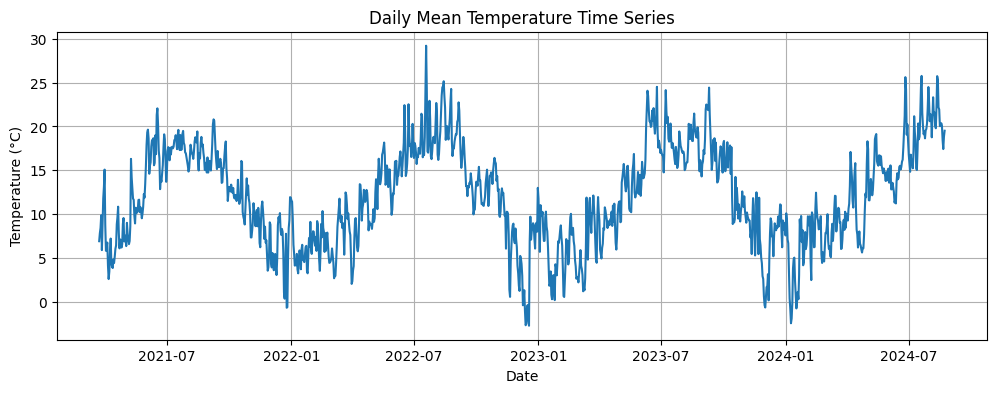

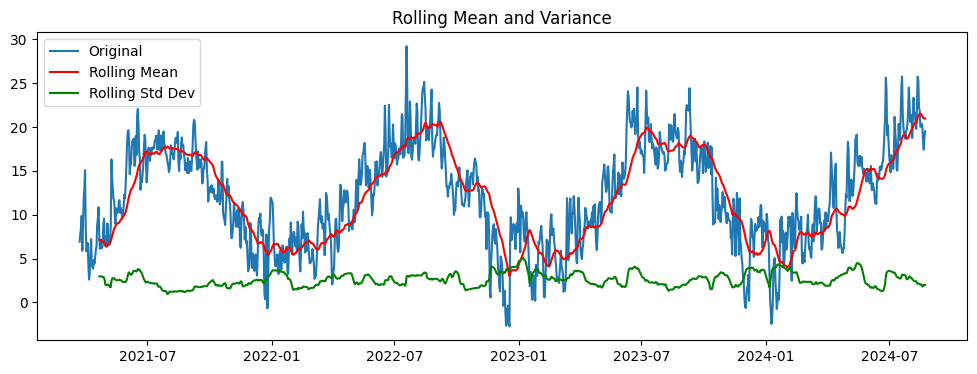

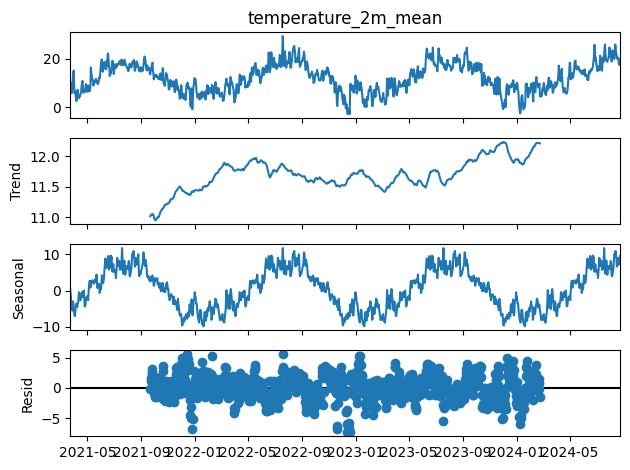

In [26]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Plot the time series
plt.figure(figsize=(12, 4))
plt.plot(daily_dataframe['temperature_2m_mean'])
plt.title("Daily Mean Temperature Time Series")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.show()

# Plot rolling mean and variance
rolling_mean = daily_dataframe['temperature_2m_mean'].rolling(window=30).mean()
rolling_std = daily_dataframe['temperature_2m_mean'].rolling(window=30).std()

plt.figure(figsize=(12, 4))
plt.plot(daily_dataframe['temperature_2m_mean'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std Dev', color='green')
plt.title("Rolling Mean and Variance")
plt.legend()
plt.show()

# Decompose the time series (assuming daily data with yearly seasonality)
decomposition = seasonal_decompose(
    daily_dataframe['temperature_2m_mean'], model='additive', period=365
)
decomposition.plot()
plt.tight_layout()
plt.show()

# Extract residuals for next task
residual = decomposition.resid.dropna()

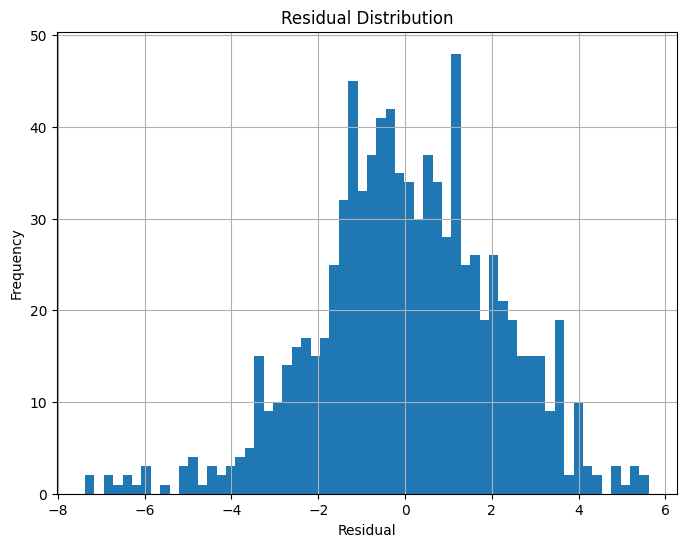

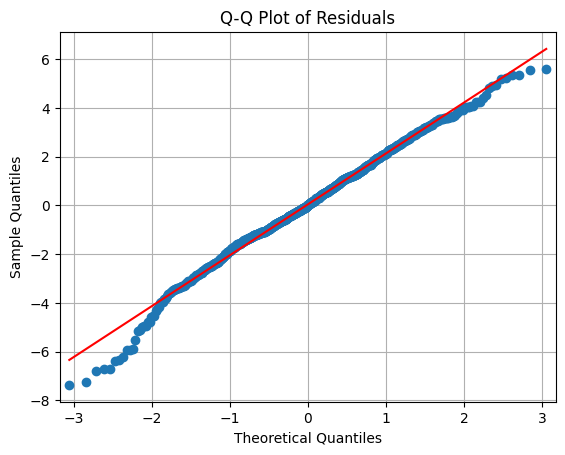

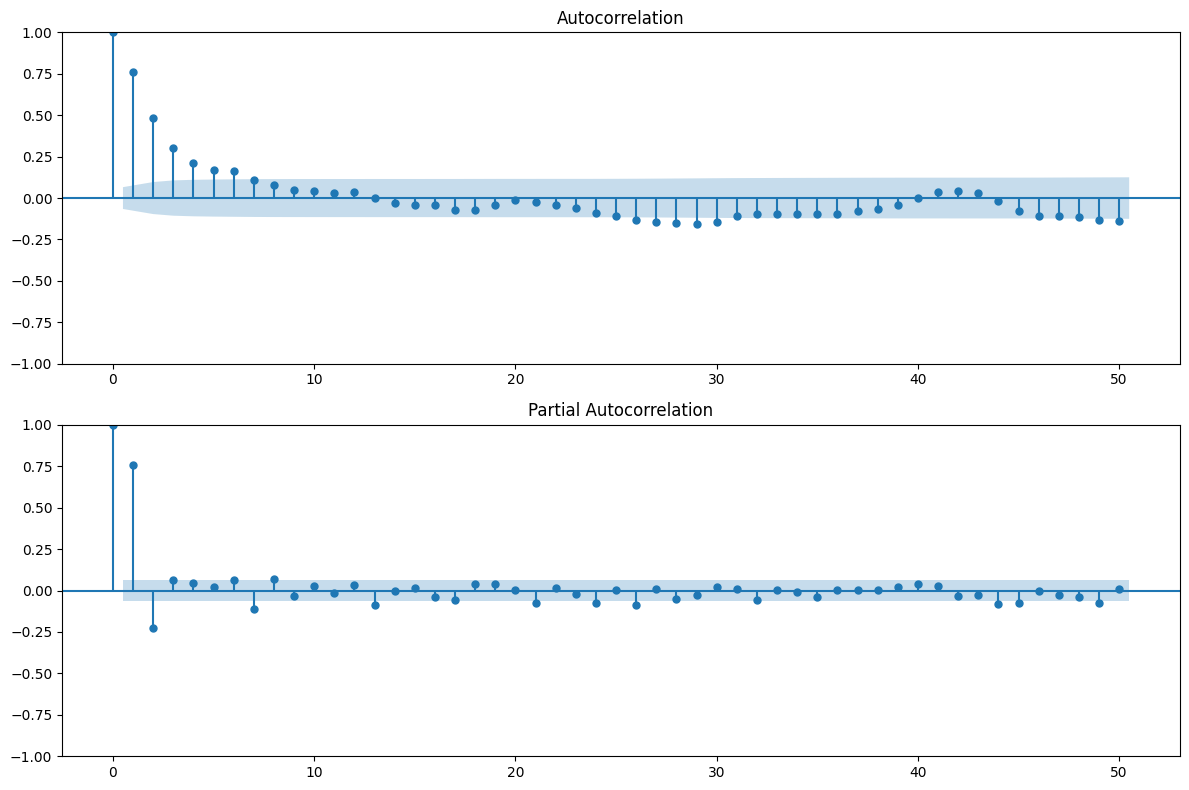

ADF Statistic: -7.935542350382916
p-value: 3.4214910219643017e-12
Critical Values: {'1%': -3.437819842246547, '5%': -2.8648374649929753, '10%': -2.5685258078777093}


In [27]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residual, bins=60)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Q-Q plot of residuals
sm.qqplot(residual, line='s')
plt.title("Q-Q Plot of Residuals")
plt.grid(True)
plt.show()

# ACF and PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(residual, ax=ax[0], lags=50)
sm.graphics.tsa.plot_pacf(residual, ax=ax[1], lags=50)
plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(residual)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])


ADF p-value < 0.05 indicates stationarity.

Q-Q plots and histogram help verify normality assumption of residuals.

ACF/PACF help in selecting ARIMA model parameters later (p, q).

In [28]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# 1. define the model: a + b·t + α·cos(ωt) + β·sin(ωt)
def seasonal_trend(t, a, b, alpha, beta):
    ω = 2 * np.pi / 365.25
    return a + b*t + alpha * np.cos(ω * t) + beta * np.sin(ω * t)

# 2. prepare xdata (days since start) and ydata
first_ord = daily_dataframe.index[0].toordinal()
xdata = np.array([d.toordinal() - first_ord for d in daily_dataframe.index])
ydata = daily_dataframe['temperature_2m_mean'].values

# 3. fit the curve
popt, pcov = curve_fit(seasonal_trend, xdata, ydata, method='lm')
a, b, alpha, beta = popt
print("Estimated parameters:")
print(f"  a (intercept)       = {a:.4f}")
print(f"  b (trend slope)     = {b:.6f} °C/day")
print(f"  α (cos amplitude)   = {alpha:.4f} °C")
print(f"  β (sin amplitude)   = {beta:.4f} °C")

# 4. compute fitted deterministic component and residuals
daily_dataframe['model_fit'] = seasonal_trend(xdata, *popt)
daily_dataframe['residuals'] = daily_dataframe['temperature_2m_mean'] - daily_dataframe['model_fit']


Estimated parameters:
  a (intercept)       = 10.6639
  b (trend slope)     = 0.001524 °C/day
  α (cos amplitude)   = -4.0563 °C
  β (sin amplitude)   = 5.6595 °C


In [29]:
import statsmodels.api as sm

# 1. select AR(p) by AIC
resid = daily_dataframe['residuals'].dropna()
# statsmodels' AutoReg can report AIC for different lags:
aic_values = {}
for p in range(1, 11):
    model = sm.tsa.AutoReg(resid, lags=p, old_names=False).fit()
    aic_values[p] = model.aic

best_p = min(aic_values, key=aic_values.get)
print(f"Selected AR order by lowest AIC: p = {best_p}")

# 2. fit the chosen AR(p)
ar_model = sm.tsa.AutoReg(resid, lags=best_p, old_names=False).fit()
print(ar_model.summary())

# 3. for AR(1) or the first coefficient of AR(p), compute mean‑reversion κ
#    if best_p >= 1, φ = ar_model.params['L1.residuals']
phi = ar_model.params[f'residuals.L1']
delta_t = 1.0  # one day
kappa = -np.log(phi) / delta_t
print(f"AR(1) coefficient φ = {phi:.4f}")
print(f"Estimated mean‑reversion κ = {kappa:.4f} per day")


Selected AR order by lowest AIC: p = 10
                            AutoReg Model Results                             
Dep. Variable:              residuals   No. Observations:                 1250
Model:                    AutoReg(10)   Log Likelihood               -2422.445
Method:               Conditional MLE   S.D. of innovations              1.707
Date:                Mon, 05 May 2025   AIC                           4868.891
Time:                        17:29:12   BIC                           4930.365
Sample:                    04-02-2021   HQIC                          4892.010
                         - 08-23-2024                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0043      0.048     -0.088      0.930      -0.099       0.091
residuals.L1      0.9665      0.028     34.156      0.000       0.911       1.022


C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCac

In [30]:
import numpy as np
import pandas as pd
from tqdm import trange

def simulate_temperature_paths(
    a, b, alpha, beta,                      # deterministic params
    phi, sigma,                             # AR(p) params: phi array length p, noise std
    start_date, n_days,                     # simulation horizon
    M=10000,                                # number of Monte Carlo paths
    seed=None
):
    """
    Returns an (n_days+1) · M array of simulated temperatures.
    """
    if seed is not None:
        np.random.seed(seed)

    # time grid
    dates = pd.date_range(start_date, periods=n_days+1, freq='D')
    tau = np.array([(d - dates[0]).days for d in dates])  # 0,1,2,...

    # deterministic part for all times
    ω = 2 * np.pi / 365.25
    T_det = a + b*tau + alpha * np.cos(ω*tau) + beta * np.sin(ω*tau)

    p = len(phi)
    # container for all paths
    T = np.zeros((n_days+1, M))
    # initialize residuals to zero at t=0 (or use historical last residuals)
    R = np.zeros((n_days+1, M))

    # set initial temperature = det + resid
    T[0, :] = T_det[0]  

    # simulate
    for i in trange(1, n_days+1):
        # simulate residuals via AR(p)
        # R[i] = sum_j phi_j*R[i-j] + eps
        eps = np.random.normal(0, sigma, size=M)
        # compute lagged contribution
        ar_part = np.zeros(M)
        for j in range(1, p+1):
            ar_part += phi[j-1] * R[i-j, :]
        R[i, :] = ar_part + eps

        # total temperature
        T[i, :] = T_det[i] + R[i, :]

    # wrap in DataFrame with MultiIndex (date, path)
    idx = pd.MultiIndex.from_product([dates, np.arange(M)], names=["date","path"])
    return pd.DataFrame({"temperature": T.ravel()}, index=idx)

# Example usage:
# — these would come from Part C fitting:
a, b, alpha, beta = popt        # intercept, trend, cos‑amp, sin‑amp
phi = ar_model.params.filter(like='L').values   # e.g. [φ1, φ2, …]
sigma = np.sqrt(ar_model.sigma2)

# simulate 365 days, 5000 paths
sim_df = simulate_temperature_paths(
    a, b, alpha, beta,
    phi, sigma,
    start_date=pd.Timestamp.today().normalize(),
    n_days=365,
    M=5000,
    seed=42
)

# quick look at first few days of path 0
print(sim_df.xs(0, level="path").head())

100%|██████████| 365/365 [00:00<00:00, 6887.14it/s]

            temperature
date                   
2025-05-05     6.607584
2025-05-06     7.554873
2025-05-07     6.903797
2025-05-08     5.608982
2025-05-09     5.529259


In [31]:
def call_with_cap(DD, K, alpha, C):
    """
    Call option on cumulative DD, capped at C.
    
    Parameters
    ----------
    DD : array‑like of float
        Cumulative degree‑days for each scenario.
    K : float
        Strike (degree‑days).
    alpha : float
        Notional per degree‑day above strike.
    C : float
        Maximum total payoff.
    
    Returns
    -------
    payoffs : ndarray
    """
    payoff = alpha * np.maximum(DD - K, 0.0)
    return np.minimum(payoff, C)


def put_with_floor(DD, K, alpha, F):
    """
    Put option on cumulative DD, floored at F.
    
    Parameters
    ----------
    DD : array‑like of float
        Cumulative degree‑days for each scenario.
    K : float
        Strike (degree‑days).
    alpha : float
        Notional per degree‑day below strike.
    F : float
        Maximum total payoff.
    
    Returns
    -------
    payoffs : ndarray
    """
    payoff = alpha * np.maximum(K - DD, 0.0)
    return np.minimum(payoff, F)


def collar(DD, K1, alpha, C, K2, beta, F):
    """
    Collar: capped call minus floored put.
    
    Parameters
    ----------
    DD : array‑like of float
        Cumulative degree‑days for each scenario.
    K1 : float
        Call strike.
    alpha : float
        Call notional per degree‑day above K1.
    C : float
        Call cap.
    K2 : float
        Put strike.
    beta : float
        Put notional per degree‑day below K2.
    F : float
        Put floor.
    
    Returns
    -------
    payoffs : ndarray
    """
    call_payoff = call_with_cap(DD, K1, alpha, C)
    put_payoff  = put_with_floor(DD, K2, beta, F)
    return call_payoff - put_payoff

In [32]:
# suppose you have a NumPy array of cumulative DD for M simulations:
DD_sim = np.random.normal(100, 20, size=10000)  # example

# price a call with strike K=90, alpha=10 €/DD, cap C=500 €
call_payoffs = call_with_cap(DD_sim, K=90, alpha=10, C=500)

# price a put with floor F=300 €
put_payoffs  = put_with_floor(DD_sim, K=110, alpha=8, F=300)

# price a collar
collar_payoffs = collar(DD_sim,
                        K1=90,  alpha=10, C=500,
                        K2=110, beta=8,  F=300)


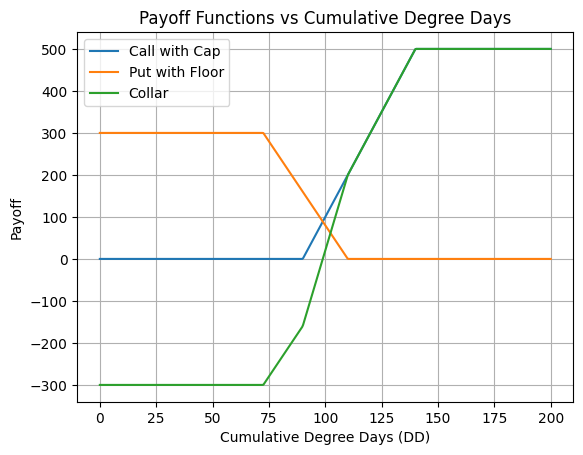

In [33]:
# Define payoff functions
def call_with_cap(DD, K, alpha, C):
    payoff = alpha * np.maximum(DD - K, 0.0)
    return np.minimum(payoff, C)

def put_with_floor(DD, K, alpha, F):
    payoff = alpha * np.maximum(K - DD, 0.0)
    return np.minimum(payoff, F)

def collar(DD, K1, alpha, C, K2, beta, F):
    call_payoff = call_with_cap(DD, K1, alpha, C)
    put_payoff  = put_with_floor(DD, K2, beta, F)
    return call_payoff - put_payoff

# Generate DD range and compute payoffs
DD_range = np.linspace(0, 200, 500)
call_payoffs = call_with_cap(DD_range, 90, 10, 500)
put_payoffs = put_with_floor(DD_range, 110, 8, 300)
collar_payoffs = collar(DD_range, 90, 10, 500, 110, 8, 300)

# Single plot with all payoffs
plt.figure()
plt.plot(DD_range, call_payoffs, label='Call with Cap')
plt.plot(DD_range, put_payoffs, label='Put with Floor')
plt.plot(DD_range, collar_payoffs, label='Collar')
plt.title("Payoff Functions vs Cumulative Degree Days")
plt.xlabel("Cumulative Degree Days (DD)")
plt.ylabel("Payoff")
plt.legend()
plt.grid(True)
plt.show()

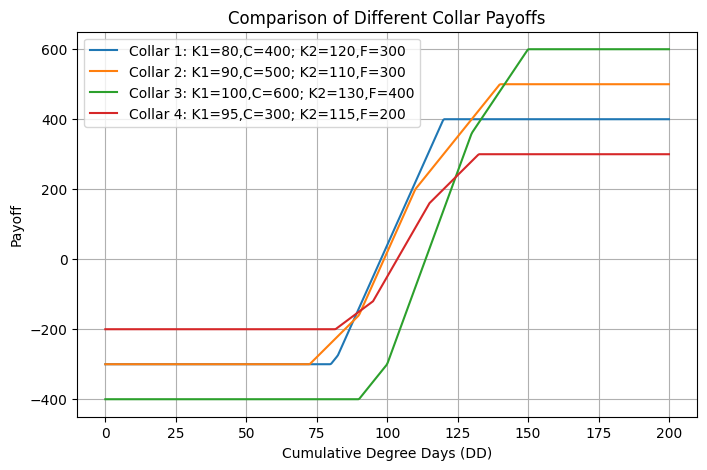

In [34]:
# Generate a range of cumulative degree days (DD)
DD_range = np.linspace(0, 200, 500)

# Define different collar parameter sets
collar_params = [
    {"K1": 80, "alpha": 10, "C": 400, "K2": 120, "beta": 8, "F": 300},
    {"K1": 90, "alpha": 10, "C": 500, "K2": 110, "beta": 8, "F": 300},
    {"K1": 100, "alpha": 12, "C": 600, "K2": 130, "beta": 10, "F": 400},
    {"K1": 95, "alpha": 8, "C": 300, "K2": 115, "beta": 6, "F": 200},
]

# Compute and plot each collar
plt.figure(figsize=(8, 5))
for i, params in enumerate(collar_params, 1):
    payoffs = collar(
        DD_range,
        params["K1"], params["alpha"], params["C"],
        params["K2"], params["beta"], params["F"]
    )
    label = (f"Collar {i}: K1={params['K1']},C={params['C']}; "
             f"K2={params['K2']},F={params['F']}")
    plt.plot(DD_range, payoffs, label=label)

plt.title("Comparison of Different Collar Payoffs")
plt.xlabel("Cumulative Degree Days (DD)")
plt.ylabel("Payoff")
plt.legend()
plt.grid(True)
plt.show()


Collar 1 (blue): wider corridor (80–120 DD), moderate cap/floor

Collar 2 (yellow): symmetric around 100 DD with higher notional

Collar 3 (green): highest notional and widest payoff range

Collar 4 (red): narrow corridor with lower cap/floor